## Create figure similar to Joakim Kjellson's T-S cycle

Fig. 8: https://www.sciencedirect.com/science/article/pii/S1463500315001560

"Monthly averages of T and S at the surface and 500 m depth in the Weddell Sea for the years 1979–1992 for all runs listed in Table 1. February (warm, fresh) is shown by diamonds and September (cold, salty) by circles. Solid lines show potential density referenced to the surface, σ 0 . Red dashed lines show the observed potential density at the surface and 500 m in September. Thick solid black line shows the freezing point of sea water."

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import plot_ts_distribution

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'
run_dir  = f'{base_dir}output/ERA5_test7/'

### T-S diagram

In [3]:
ds_mesh = xr.open_dataset(nemo_mesh)
zind_surf = 0 
zind_500  = 50

## weddell sea mask:


In [4]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}

In [5]:
# load nemo simulations
gridT_files = glob.glob(f'{run_dir}files/*grid_T*')[0:2] # load all the gridT files in the run folder
nemo_ds = xr.open_mfdataset(gridT_files).rename({'x_grid_T':'x','y_grid_T':'y'}) 

In [11]:
kwags1 = {'x':weddell_overall['x'], 'y':weddell_overall['y'], 'time_counter':(nemo_ds.time_counter.dt.month==9)}

zind = zind_surf
salt = nemo_ds.so.isel(deptht=zind, **kwags1).mean(dim='time_counter')
salt = salt.where(salt!=0)
temp = nemo_ds.thetao.isel(deptht=zind, **kwags1).mean(dim='time_counter')
temp = temp.where(temp!=0)

density_surf = gsw.density.sigma0(salt, temp)

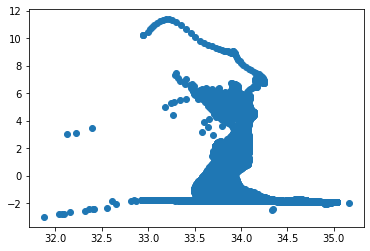

In [14]:
plt.scatter(salt, temp)

KeyboardInterrupt: 

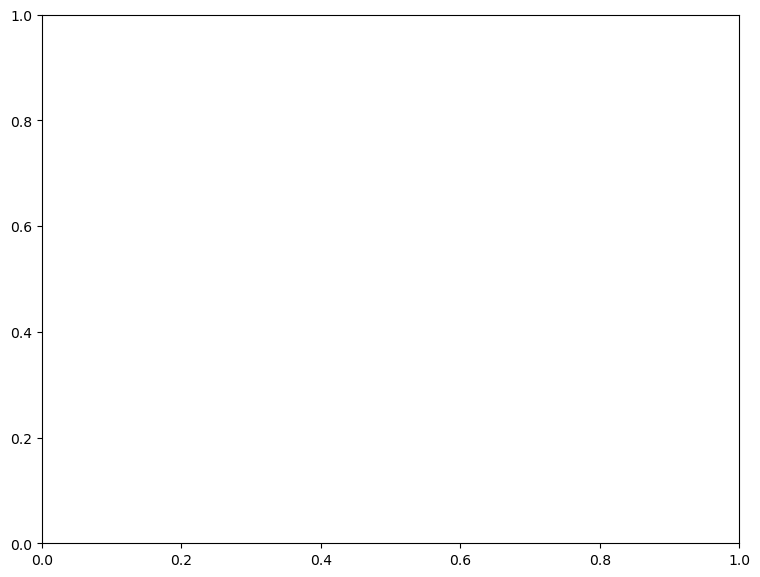

In [31]:
fig, ax = plt.subplots(1,1,figsize=(9,7), dpi=100)

years = np.unique(nemo_ds.time_counter.dt.year)

# for year in years: 
#     kwags = {'x':weddell_overall['x'], 'y':weddell_overall['y'], 
#              'time_counter':(nemo_ds.time_counter.dt.year==year) | (nemo_ds.time_counter.dt.year==year+1)*(nemo_ds.time_counter.dt.month==1)}
#     salt_500  = nemo_ds.so.isel(deptht=zind_500, **kwags)
#     temp_500  = nemo_ds.thetao.isel(deptht=zind_500, **kwags)
#     salt_surf = nemo_ds.so.isel(deptht=zind_surf, **kwags)
#     temp_surf = nemo_ds.thetao.isel(deptht=zind_surf, **kwags)

#     salt_500  = salt_500.where(salt_500!=0).mean(dim=['x','y']) 
#     temp_500  = temp_500.where(temp_500!=0).mean(dim=['x','y']) 
#     salt_surf = salt_surf.where(salt_surf!=0).mean(dim=['x','y']) 
#     temp_surf = temp_surf.where(temp_surf!=0).mean(dim=['x','y']) 

#     ax.plot(salt_surf, temp_surf, '-o') # add color for year
#     ax.plot(salt_500, temp_500, '-o')

# Red dashed lines show the observed potential density at the surface and 500 m in September.
kwags1 = {'x':weddell_overall['x'], 'y':weddell_overall['y'], 'time_counter':(nemo_ds.time_counter.dt.month==9)}
density_surf = gsw.density.sigma0(nemo_ds.so.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter'), 
                                  nemo_ds.thetao.isel(deptht=zind_surf,**kwags1).mean(dim='time_counter'))
density_500  = gsw.density.sigma0(nemo_ds.so.isel(deptht=zind_500, **kwags1).mean(dim='time_counter'), 
                                  nemo_ds.thetao.isel(deptht=zind_500,**kwags1).mean(dim='time_counter'))

ax.contour(nemo_ds.so.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter'), 
           nemo_ds.thetao.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter'), 
           density_surf, colors='red', linestyles='dashed', zorder=2)
ax.contour(nemo_ds.so.isel(deptht=zind_500, **kwags1).mean(dim='time_counter'), 
           nemo_ds.thetao.isel(deptht=zind_500, **kwags1).mean(dim='time_counter'), 
           density_500, colors='red', linestyles='dashed', zorder=2)

ax.set_xlabel('Absolute Salinity')
ax.set_ylabel('Conservative Temperature')

In [ ]:
nemo_ds.so.isel(deptht=zind_surf, **kwags1).mean(dim='time_counter')

In [ ]:
# Function to plot a 2D histogram of temperature and salinity values on an axis you pass it
# Inputs:
# ax           : matplotlib axis
# salt         : absolute salinity
# temp         : conservative temperature
# smin, smax, tmin, tmax : (optional) bounds for the salinity and temperature axes
# plot_density : (optional) boolean specifying whether to plot dashed lines of constant potential density in the background
# plot_freeze  : (optional) boolean specifying whether to plot dashed line of surface freezing temperature in the background
# lognorm      : (optional) boolean specifying whether to log normalize the histogram counts
# bins         : (optional) number of bins of histogram
def plot_ts(ax, salt, temp, smin=30, smax=35.25, tmin=-3, tmax=2.25, plot_density=False, 
            plot_freeze=False):

    import gsw
    import gsw.freezing as fr

    # Plot surface freezing temperature line
    if plot_freeze:
        tfreeze_sfc = fr.CT_freezing(np.linspace(smin, smax), 0, 0) # saturation_fraction=0
        ax.plot(np.linspace(smin, smax), tfreeze_sfc, color='black', linestyle='dashed', zorder=1)

    # Plot contours of potential density
    if plot_density:
        salt_2d, temp_2d = np.meshgrid(np.linspace(smin, smax), np.linspace(tmin, tmax))
        density = gsw.density.sigma0(salt_2d, temp_2d)
        ax.contour(salt_2d, temp_2d, density, colors='DarkGrey', linestyles='dotted', zorder=2)
    
    
    ax.set_xlim(smin, smax)
    ax.set_ylim(tmin, tmax)
    ax.set_xlabel('Absolute Salinity')
    ax.set_ylabel('Conservative Temperature')

    return

In [4]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None)):
    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name = 'area_grid_T'
    name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var, var_ocean

In [6]:
# run_dir = f'{base_dir}output/ERA5_test6_highres/files2/'
run_dir = f'{base_dir}output/ERA5_evd_test2/files/'
time_slice=(0,None)

region = weddell_overall

# # weddell_T, T         = extract_region_var(run_dir, 'thetao' , region, file_slice=time_slice, file_type='grid_T')
# # weddell_S, S         = extract_region_var(run_dir, 'so'     , region, file_slice=time_slice, file_type='grid_T')